# Exploraci√≥n de Datos: Letras Din√°micas

Este notebook realiza un an√°lisis exploratorio (EDA) del conjunto de datos de letras din√°micas en Lengua de Se√±as Mexicana (LSM), representadas como secuencias de frames extra√≠dos de videos.

Analizaremos la distribuci√≥n de secuencias, duraci√≥n de los clips (n√∫mero de frames), ejemplos visuales y consistencia del dataset.

In [14]:
from pyprojroot import here
from pathlib import Path
import pandas as pd
import ast

# Cargar CSV con listas de frames por secuencia
csv_path = here() / "data/letters/dynamics_sequences.csv"
df = pd.read_csv(csv_path)
df["frames"] = df["frames"].apply(ast.literal_eval)
df.head()

frames label
0  [data/letters/dynamics/J/S1-J-perfil-1/frame_0...     J
1  [data/letters/dynamics/J/S1-J-perfil-2/frame_0...     J
2  [data/letters/dynamics/J/S1-J-perfil-3/frame_0...     J
3  [data/letters/dynamics/J/S1-J-perfil-4/frame_0...     J
4  [data/letters/dynamics/J/S1-J-perfil-5/frame_0...     J

## Distribuci√≥n de secuencias por clase

Visualizamos la cantidad de secuencias por letra din√°mica para evaluar balance de clases.

C:\Users\Jamin\AppData\Local\Temp\ipykernel_10024\8500252.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="crest")


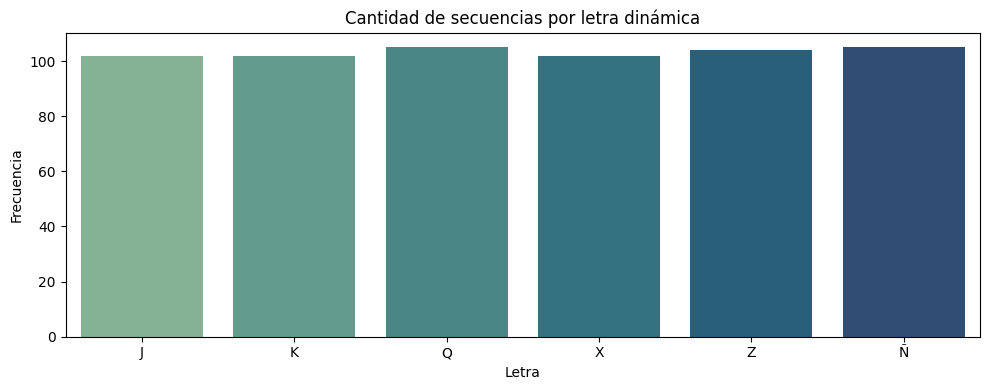

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="label", palette="crest")
plt.title("Cantidad de secuencias por letra din√°mica")
plt.xlabel("Letra")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## Duraci√≥n de las secuencias (frames por gesto)

Calculamos cu√°ntos frames tiene cada secuencia para detectar si hay mucha variabilidad en la duraci√≥n de los clips.

In [17]:
df["n_frames"] = df["frames"].apply(len)
df["n_frames"].describe()

count    620.000000
mean      16.245161
std        4.883578
min        7.000000
25%       13.000000
50%       15.500000
75%       19.000000
max       38.000000
Name: n_frames, dtype: float64

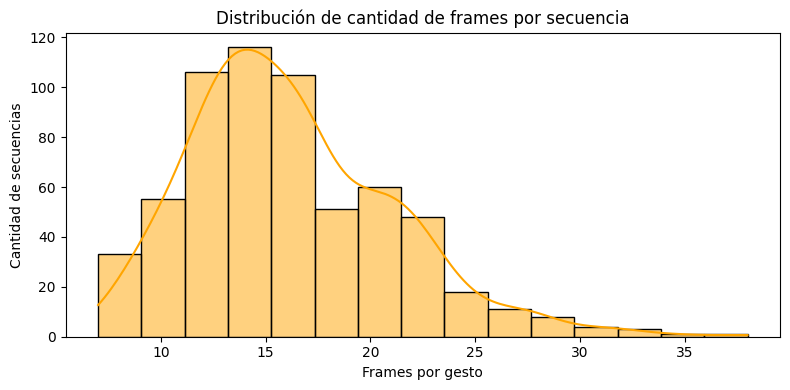

In [19]:
plt.figure(figsize=(8, 4))
sns.histplot(df["n_frames"], bins=15, kde=True, color="orange")
plt.title("Distribuci√≥n de cantidad de frames por secuencia")
plt.xlabel("Frames por gesto")
plt.ylabel("Cantidad de secuencias")
plt.tight_layout()
plt.show()

## Verificaci√≥n de integridad

Nos aseguramos de que los archivos de imagen mencionados realmente existan y se puedan acceder.

In [20]:
from tqdm import tqdm

missing = []
for paths in tqdm(df["frames"], desc="Verificando rutas"):
    for p in paths:
        if not (here() / p).exists():
            missing.append(p)

print(f"‚ùå Archivos perdidos: {len(missing)}")
if missing:
    print(missing[:5])

Verificando rutas: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 620/620 [00:04<00:00, 126.05it/s]

‚ùå Archivos perdidos: 0


## Visualizaci√≥n de una secuencia por clase

Seleccionamos una secuencia aleatoria por letra y mostramos sus primeros frames para observar los gestos.

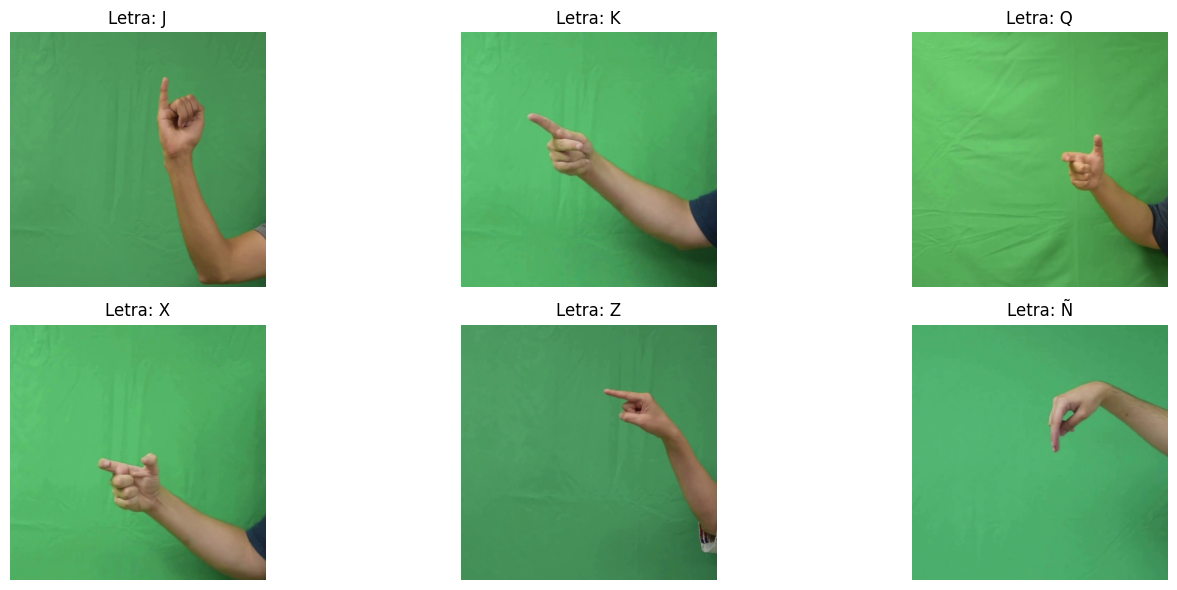

In [26]:
import numpy as np
import cv2

def imread_u8(p):
    buf = np.fromfile(p, dtype=np.uint8)          # Lee bytes (Unicode OK)
    return cv2.imdecode(buf, cv2.IMREAD_COLOR)    # Decodifica

letters = sorted(df["label"].unique())
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()

for i, letra in enumerate(letters):
    frames = df[df["label"] == letra].sample(1).iloc[0]["frames"]
    frame_path = here() / Path(frames[min(2, len(frames)-1)])

    if not frame_path.exists():
        print(f"‚ùå No existe: {frame_path}")
        continue

    img = imread_u8(frame_path)
    if img is None:
        print(f"‚ö†Ô∏è  OpenCV no pudo leer {frame_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Letra: {letra}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## An√°lisis de distribuci√≥n mediante PCA + UMAP
Para explorar la separabilidad entre las clases din√°micas, se aplic√≥ una reducci√≥n de dimensionalidad utilizando PCA (para reducir ruido) seguido de UMAP (para visualizar agrupamientos no lineales). Esto permite observar c√≥mo se distribuyen las distintas letras din√°micas en un espacio bidimensional.

c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


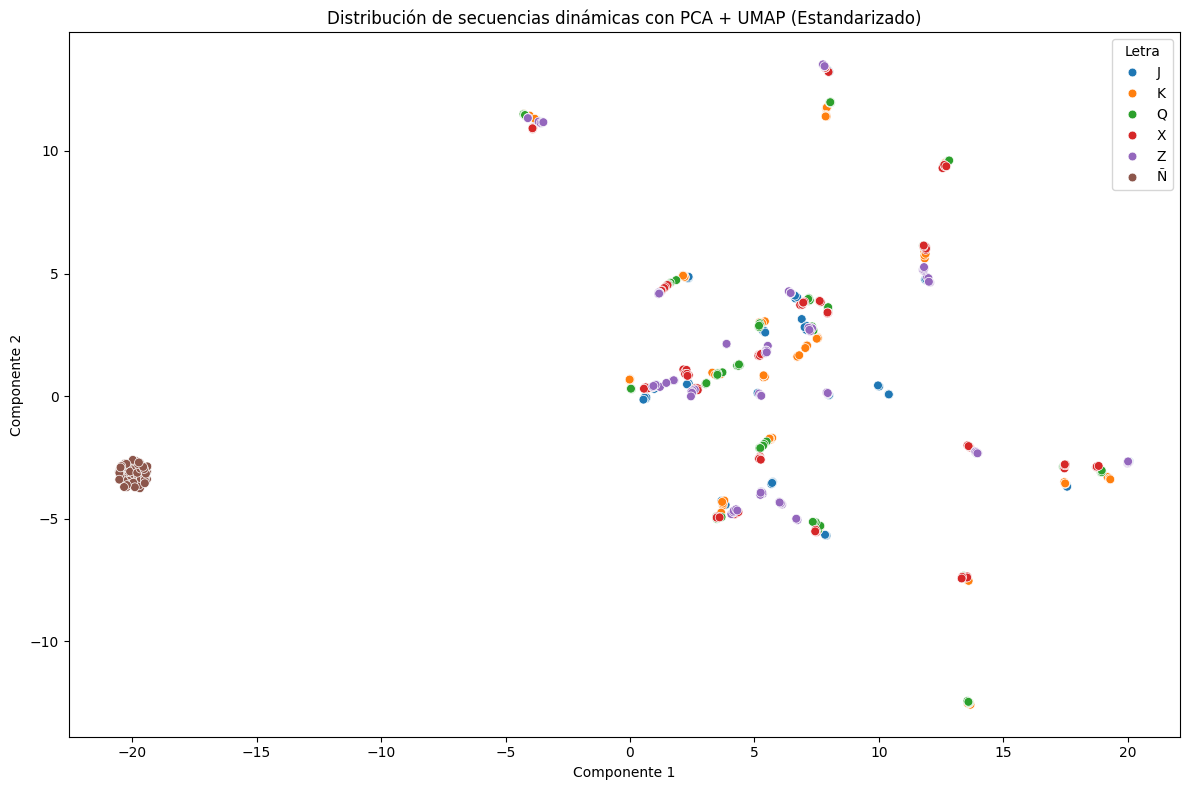

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

# Vectorizar secuencias promediando los frames redimensionados
def vectorizar_secuencia(frame_paths):
    frames = [cv2.imread(str(here() / f)) for f in frame_paths]
    frames = [f for f in frames if f is not None]
    arr = np.array([cv2.resize(f, (64,64)).flatten() for f in frames])
    return arr.mean(axis=0) if len(arr) > 0 else np.zeros(64*64*3)

# Aplicar vectorizaci√≥n a todas las secuencias
X = np.vstack(df['frames'].apply(vectorizar_secuencia).to_list())
y = df['label'].to_numpy()

# üîπ Estandarizaci√≥n antes de PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# üî∏ Paso 1: PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# üî∏ Paso 2: UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_pca)

# Crear DataFrame para visualizaci√≥n
df_umap = pd.DataFrame(X_umap, columns=['Componente 1', 'Componente 2'])
df_umap['Letra'] = y

# Visualizaci√≥n
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_umap, x='Componente 1', y='Componente 2', hue='Letra', palette='tab10', s=40)
plt.title("Distribuci√≥n de secuencias din√°micas con PCA + UMAP (Estandarizado)")
plt.legend(title="Letra")
plt.tight_layout()
plt.show()

## Conclusiones

- Se detectaron correctamente las 6 letras din√°micas del LSM: **J, K, √ë, Q, X, Z**.
- Se extrajeron un total de **620 secuencias** de video, una cantidad equilibrada entre clases.
- La duraci√≥n promedio de cada gesto es de aproximadamente **16 frames**, con valores entre 7 y 38.
- La distribuci√≥n de frames por secuencia sigue una forma parecida a una distribuci√≥n normal, con un ligero sesgo a la derecha.
- No se encontraron secuencias con rutas de im√°genes perdidas o con errores de lectura.
- Se visualiz√≥ correctamente una muestra representativa de cada gesto din√°mico.
- Se aplic√≥ una reducci√≥n de dimensionalidad con **PCA + UMAP**, previa estandarizaci√≥n de las secuencias vectorizadas.
- La visualizaci√≥n en 2D mostr√≥ **una buena separaci√≥n entre clases**, especialmente para la letra **√ë**, que forma un grupo compacto y bien definido.

> Estos resultados confirman que el dataset din√°mico est√° limpio, balanceado y visualmente interpretable, lo que permite su uso en modelos de aprendizaje profundo como **RNN**, **LSTM** o modelos con atenci√≥n. La representaci√≥n reducida tambi√©n podr√≠a ser √∫til para tareas exploratorias o como preprocesamiento para clustering o clasificaci√≥n.